In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import transformers
import torch
from transformers import pipeline
import string
from transformers import BertTokenizer, BertForMaskedLM
import statistics

from valuemap.models import Model, MultiModel
from valuemap.values import ValueMap, ValueSearch
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors

In [2]:
def load_dataset():
    # Load the dataset into separate DataFrames for each split
    df_training = pd.read_csv('arguments-training.tsv', delimiter='\t')
    df_validation = pd.read_csv('arguments-validation.tsv', delimiter='\t')
    df_test = pd.read_csv('arguments-test.tsv', delimiter='\t')

    # Concatenate all the dataframes
    df = pd.concat([df_training, df_validation, df_test])

    # Extract the argument text from each DataFrame
    arguments = df['Premise'].tolist()
    stances = df['Stance'].tolist()
    conclusions = df['Conclusion'].tolist()

    return arguments, stances, conclusions

In [3]:
def process_sentences(sentences):
    processed = []
    for sentence in sentences:
        # Remove punctuation
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        # Convert to lowercase
        sentence = sentence.lower()
        processed.append(sentence)
    return processed

In [4]:
# model inizialization
model_bert = pipeline('fill-mask', model='bert-base-uncased') # Bert

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# model inizialization for adjectiveList-based approach
def load_model() :
    # Load the model and tokenizer
    model = BertForMaskedLM.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return model, tokenizer

model, tokenizer = load_model()[0], load_model()[1]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model t

In [6]:
# Load dataset
arguments, stances, conclusions = load_dataset()

# Preprocess premise and conclusion
arguments = process_sentences(arguments)
conclusions = process_sentences(conclusions)

In [7]:
# Map each argument to the corresponding stance and conclusion
if len(arguments) != len(stances) or len(arguments) != len(conclusions):
    print("Error: incompatible data")
else:
    input = {}
    for i in range(len(arguments)):
        input[arguments[i]] = (stances[i], conclusions[i])

In [8]:
def radial_plot(results):
    # Create a list of adjectives and their probabilities
    adjectives = list(results.keys())
    probabilities = list(results.values())

    # Compute angle for each adjective
    angles = np.linspace(0, 2 * np.pi, len(adjectives), endpoint=False).tolist()

    # The figure is plotted in a polar projection
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))
    
    # Plot each line separately
    for i in range(len(adjectives)):
        ax.plot([angles[i], angles[i]], [0, probabilities[i]], color='blue')
    
    # Fill the area under the curve
    ax.fill(angles, probabilities, 'blue', alpha=0.1)
    
    # Set the yticks to be empty and xticks to be the adjectives
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(adjectives)
    
    # Display the plot
    plt.show()

In [9]:
import random

# Random argument selection
input_argument = random.choice(list(input.keys()))

argument = input_argument
stance = input[input_argument][0]
conclusion = input[input_argument][1]

In [10]:
def generate_prompt(stance, conclusion, argument):
    return f"i am {stance} the fact that {conclusion} because i think that {argument}. i am a {tokenizer.mask_token}."

In [11]:
def generate_word(model):
    # Initialize an empty list to store the results
    results = []

    # Create prompt 
    prompt = generate_prompt(stance, conclusion, argument)
    
    # Generate the filling
    output = model(prompt)
   
    # Sort output by 'score'
    output.sort(key=lambda x: x['score'], reverse=True)
    
    # Create a dictionary of other predicted words with their scores
    predictions = {result['token_str']: result['score'] for result in output}

    # Extract 'sequence' with higher 'score'
    description = output[0]['sequence']
    
    return predictions, description

In [12]:
generate_word(model_bert)

({'christian': 0.10297702252864838,
  'conservative': 0.10118106007575989,
  'libertarian': 0.08582311123609543,
  'atheist': 0.07207819074392319,
  'feminist': 0.06986771523952484},
 'i am against the fact that holocaust denial should be a criminal offence because i think that it should not a criminal offence as it is just an opinion rather than actually committing a crime. i am a christian.')

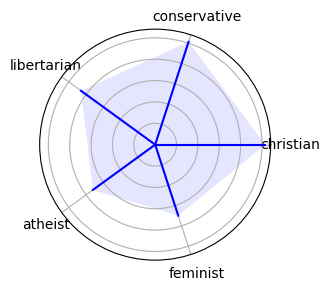

In [13]:
radial_plot(generate_word(model_bert)[0])

In [14]:
adjective_list = [ 
    "conservative","republican","capitalist",
    "libertarian","centrist","democrat",
    "liberal","progressive","socialist",
    "communist","anarchist",
]

In [15]:
def sort_elements(element) :
    sorted_element = {k: v for k, v in sorted(element.items(), key=lambda item: item[1], reverse=True)}
    return sorted_element

In [16]:
def generate_word_adj(model, tokenizer, adjective_list):
    # Create prompt 
    prompt = generate_prompt(stance, conclusion, argument)
    
    # Initialize a dictionary to store the probabilities
    probabilities = {}
    # For each word in the list, generate a score
    for word in adjective_list:
        # Replace the mask token with the word
        new_prompt = prompt.replace(tokenizer.mask_token, word)
        # Encode the new prompt
        inputs = tokenizer.encode_plus(new_prompt, return_tensors='pt')
        # Generate the filling
        outputs = model(**inputs)
        logits = outputs.logits
        # Calculate the softmax probabilities from logits
        softmax_probs = torch.nn.functional.softmax(logits, dim=-1)
        # Get the probability of the word
        word_id = tokenizer.encode(word, add_special_tokens=False)[0]
        word_prob = softmax_probs[0, -1, word_id].item()

        # Store the probability of the word
        probabilities[word] = word_prob

    # Sort the probabilities dictionary by value in descending order
    sorted_probabilities = sort_elements(probabilities)

    # Choose the word with the highest probability
    top_word = next(iter(sorted_probabilities))

    # Replace the mask token in the original prompt with the top word
    description = prompt.replace(tokenizer.mask_token, top_word)

    return probabilities, sorted_probabilities, description

In [17]:
desc_order_probabilities = generate_word_adj(model, tokenizer, adjective_list)[1]
political_order_probabilities = generate_word_adj(model, tokenizer, adjective_list)[0]

In [18]:
generate_word_adj(model, tokenizer, adjective_list)[1:]

({'republican': 1.5998548263951307e-08,
  'communist': 1.202856125814833e-08,
  'socialist': 6.032726762583707e-09,
  'liberal': 3.7582097434096795e-09,
  'capitalist': 2.004623800289096e-09,
  'conservative': 1.0764484859038248e-09,
  'progressive': 5.77596248607648e-10,
  'democrat': 3.545516380487612e-10,
  'libertarian': 1.6283722981125237e-10,
  'anarchist': 1.3141329170685001e-11,
  'centrist': 1.25479730772593e-11},
 'i am against the fact that holocaust denial should be a criminal offence because i think that it should not a criminal offence as it is just an opinion rather than actually committing a crime. i am a republican.')

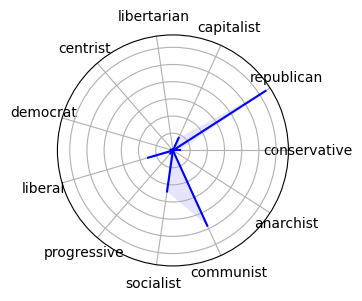

In [19]:
radial_plot(political_order_probabilities)

In [20]:
en_path = 'C:/Users/ffraa/Desktop/Università/Tesi/vast-value-map-main/valuemap/Data/wiki.en.vec'
n_max = 100000
eng = Model(en_path, n_max=n_max)
oracle = MultiModel(eng=eng)
vocabulary_path = 'C:/Users/ffraa/Desktop/Università/Tesi/vast-value-map-main/valuemap/Refined_dictionary.txt'
value_map = ValueMap.from_vocabulary(vocabulary_path) 
value_oracle = ValueSearch(valuemap=value_map, oracle=oracle, k=10, depth=2)

In [21]:
# Load pretrained word2vec model
path = 'C:/Users/ffraa/Desktop/Università/Tesi/vast-value-map-main//valuemap/GoogleNews-vectors-negative300.bin'
similarity_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [22]:
def find_closest_word(word, dictionary, model):
    # Get the embedding for the predicted word
    word_embedding = model[word]
    max_similarity = -1
    closest_word = None
    # Iterate over all words in the dictionary
    for dict_word in dictionary.keys():
        try:
            # Get the embedding for the word from the dictionary
            dict_word_embedding = model[dict_word]

            # Calculate the cosine similarity between the two embeddings
            similarity = cosine_similarity([word_embedding], [dict_word_embedding])

            # If the similarity is higher than the current maximum, update the maximum
            if similarity > max_similarity:
                max_similarity = similarity
                closest_word = dict_word
        except KeyError:
            continue  # Continue if the word isn't into the model
    return closest_word

In [23]:
def calculate_oracle_answer(word):
    answers = value_oracle.search(word, lang='eng')
    aggregated = value_oracle.aggregated_search(word, lang='eng')
    
    if answers is not None:
        # Convert the aggregated values to a series and normalize them
        aggregated_series = pd.Series(aggregated).sort_values(ascending=False) / sum(aggregated.values())
        
        return answers, aggregated_series

    return None, None

In [24]:
def human_value_detection(word, dictionary, model, aggregated_values):
    
    try:
        # Calculate answers
        print(f"\n{word}")
        answers, aggregated = calculate_oracle_answer(word)
        
        if not answers :
            print(f"No values available for the word. Finding the closest word in the dictionary...")
            closest_word = find_closest_word(word, dictionary, model)
            print(f"The closest word in the dictionary for {word} is {closest_word}.")        
            # Closest word's answers
            answers, aggregated = calculate_oracle_answer(closest_word)
        # Print answers 
        sorted_answers = sorted(answers, key=lambda x: x['similarity'], reverse=True)
        for answer in sorted_answers:
            print(f"{answer}")

        # Add aggregate values
        for value, probability in aggregated.items():
            if value in aggregated_values:
                aggregated_values[value] += probability
            else:
                aggregated_values[value] = probability
    except KeyError as e:
        print(e)
    # Normalize aggregated values
    total_probability = sum(aggregated_values.values())
    normalized_values = {value: probability / total_probability for value, probability in aggregated_values.items()}
    
    return normalized_values

In [25]:
aggregated_values = {}
for word in generate_word(model_bert)[0].keys():
    aggregated_values = human_value_detection(word, value_map, similarity_model, aggregated_values)


christian
{'value': 'Tradition', 'word': 'christians', 'similarity': 0.6384504606880823, 'depth': 0}
{'value': 'Tradition', 'word': 'christianity', 'similarity': 0.6325331826983054, 'depth': 0}
{'value': 'Tradition', 'word': 'protestant', 'similarity': 0.5737594934697623, 'depth': 0}

conservative
{'value': 'Conformity', 'word': 'conservative', 'similarity': 1.0, 'depth': 0}
{'value': 'Universalism', 'word': 'liberal', 'similarity': 0.8551696815099271, 'depth': 0}

libertarian
No values available for the word. Finding the closest word in the dictionary...
The closest word in the dictionary for libertarian is liberal.
{'value': 'Universalism', 'word': 'liberal', 'similarity': 1.0, 'depth': 0}
{'value': 'Conformity', 'word': 'conservative', 'similarity': 0.855169681509927, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6624991470620656, 'depth': 0}

atheist
{'value': 'Tradition', 'word': 'atheist', 'similarity': 0.9999999999999999, 'depth': 0}

feminist
No va

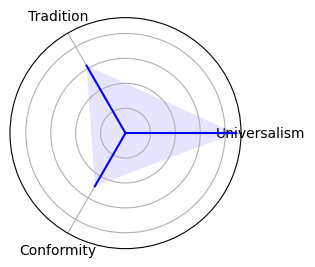

{'Universalism': 0.44151831958938365, 'Tradition': 0.31250000000000006, 'Conformity': 0.24598168041061638}


In [26]:
#Print radial plot containing all the occurencies for the values in sorted order
sorted_aggregated_values = sort_elements(aggregated_values)
radial_plot(sorted_aggregated_values)
print(sorted_aggregated_values)

In [27]:
aggregated_values_adj = {}
for word in generate_word_adj(model, tokenizer, adjective_list)[1].keys() :
    aggregated_values_adj = human_value_detection(word, value_map, similarity_model, aggregated_values_adj)


republican
{'value': 'Universalism', 'word': 'democratic', 'similarity': 0.7375593422348615, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.6799039818041741, 'depth': 0}

communist
No values available for the word. Finding the closest word in the dictionary...
The closest word in the dictionary for communist is democratic.
{'value': 'Universalism', 'word': 'democratic', 'similarity': 1.0000000000000002, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'similarity': 0.7329228397345742, 'depth': 0}
{'value': 'Hedonism', 'word': 'party', 'similarity': 0.623198907817222, 'depth': 0}

socialist
No values available for the word. Finding the closest word in the dictionary...
The closest word in the dictionary for socialist is liberal.
{'value': 'Universalism', 'word': 'liberal', 'similarity': 1.0, 'depth': 0}
{'value': 'Conformity', 'word': 'conservative', 'similarity': 0.855169681509927, 'depth': 0}
{'value': 'Universalism', 'word': 'democrats', 'simila

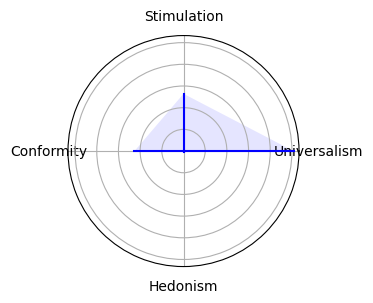

{'Universalism': 0.5072966244844674, 'Stimulation': 0.26426107451247777, 'Conformity': 0.22611757641850028, 'Hedonism': 0.002324724584554556}


In [28]:
#Print radial plot containing all the occurencies for the values in sorted order
sorted_aggregated_values_adj = sort_elements(aggregated_values_adj)
radial_plot(sorted_aggregated_values_adj)
print(sorted_aggregated_values_adj)

In [29]:
# Import the human values from values.py labels
from valuemap.values import VALUE_LABELS

In [30]:
# For the guided approach, it's used an a-priori association between adjectives and human values
mapped_adjective_values = {
    "conservative": ['1', '3', '2'],
    "republican": ['1', '9', '10'],
    "capitalist": ['6', '9', '10'],
    "libertarian": ['6', '7', '8'],
    "centrist": ['4', '5', '2'],
    "democrat": ['5', '4', '6'],
    "liberal": ['5', '7', '6'],
    "progressive": ['5', '7', '4'],
    "socialist": ['5', '4', '1'],
    "communist": ['5', '1', '4'],
    "anarchist": ['6', '7', '8'],
}

for adjective, values in mapped_adjective_values.items():
    print(f"{adjective}: {[VALUE_LABELS[value] for value in values]}")

conservative: ['Security', 'Tradition', 'Conformity']
republican: ['Security', 'Achievement', 'Power']
capitalist: ['Self-Direction', 'Achievement', 'Power']
libertarian: ['Self-Direction', 'Stimulation', 'Hedonism']
centrist: ['Benevolence', 'Universalism', 'Conformity']
democrat: ['Universalism', 'Benevolence', 'Self-Direction']
liberal: ['Universalism', 'Stimulation', 'Self-Direction']
progressive: ['Universalism', 'Stimulation', 'Benevolence']
socialist: ['Universalism', 'Benevolence', 'Security']
communist: ['Universalism', 'Security', 'Benevolence']
anarchist: ['Self-Direction', 'Stimulation', 'Hedonism']


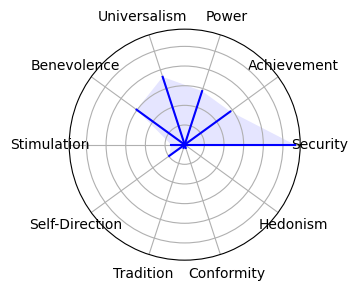

{'Security': 0.2798123939672672,
 'Achievement': 0.14337061266411041,
 'Power': 0.14337061266411041,
 'Universalism': 0.18128562983309762,
 'Benevolence': 0.1513566355697409,
 'Stimulation': 0.03463341013782476,
 'Self-Direction': 0.048821248760364006,
 'Tradition': 0.008572438144494121,
 'Conformity': 0.008672365567359383,
 'Hedonism': 0.00010465269163117053}

In [31]:
desc_order = {}
value_probs = {}

for adj, prob in desc_order_probabilities.items():
    human_value = mapped_adjective_values.get(adj)
    if human_value is not None:
        human_value = [VALUE_LABELS.get(k) for k in human_value]
        if None not in human_value:
            desc_order[tuple(human_value)] = prob
            
for values, prob in desc_order.items():
    for value in values:
        if value not in value_probs:
            value_probs[value] = 0
        value_probs[value] += prob

total_prob = sum(value_probs.values())

# Normalize
normalized_probs = {k: v / total_prob for k, v in value_probs.items()}

radial_plot(normalized_probs)
normalized_probs